
<font size="4">**Analyzing Apprentice Chef, Inc. data**</font><br /> 

Created on Fri March 09 14:42:35 2020

@author:Patricia de Melo Maia 
cohort: 5 - Valencia

***
<h3>1. Preparation</h3>

Calling libraries.
***

In [1]:

# Importing libraries
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix        
from sklearn.metrics import roc_auc_score           
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.neighbors import KNeighborsRegressor   
from sklearn.tree import export_graphviz            
from IPython.display import Image 
from sklearn.ensemble import GradientBoostingRegressor
import pydotplus 

C:\Users\patty\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


***
<h3>2. Examination</h3><br>
After import libraries,I load the data as *apprendice*. With the data loaded, I will check: the first 8 rows, if there is any missing value, statistic description(mean, std,...) and info about dataset.

Checking for anomalies, I detect that the variables: 'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON', 'PC_LOGINS', 'MOBILE_LOGINS', 'EARLY_DELIVERIES', 'LATE_DELIVERIES', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER' are irrelevant in this problem. 

***

In [2]:
##########################################################################################################
#Inicialization #########################################################################################
##########################################################################################################

# loading data
apprendice = pd.read_excel('Apprentice_Chef_Dataset.xlsx')

# setting pandas print options
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', 100)

# displaying the the first 8 rows of the dataset
#apprendice.head(n = 8)

#apprendice.info
#apprendice.description

#Checking for missing values
#apprendice.isnull.sum()



***
<h3>Transforming 'FAMILY_NAME' column</h3><br>
According to my previus analysis of data set, the only column with missing Also, values is FAMILY_NAME (47 missing values). My assumption is that: 

    (1) Users chose not to fill out a field tied to their beliefs about how the results would be used or interpreted.
    (2) Or data was missed.
    (3) it is possible a person does not have a family name.
    (4) People can avoid use the family name because of discrimination.

Also,  family members influence in the decision of subscribe the promotion or not. According to webpage https://notesmatic.com/2017/03/what-role-does-family-play-in-consumer-behavior/:"A family where the level of cohesion and communication between the family members is high, buying decisions are made keeping others' preferences in mind."

My strategy for FAMILY_NAME is find familiar relationship between the persons in the list and check if the family is influencing the CROSS_SUCCESS_SELL. Process: flag missing values, split the names, checking name that shows relationship, create RELATIVE column and drop FAMILY_NAME.
***

In [3]:
#Step 1: Flagging missing values

for col in apprendice:

# creating columns with 1s if missing and 0 if not
    if apprendice[col].isnull().astype(int).sum() > 0:    
        apprendice['m_'+col] = apprendice[col].isnull().astype(int)

################################################################################################
#STEP 2:splitting names and checking name that shows relationship.

# placeholder list
placeholder_lst = []

# looping over each NAME
for index, col in apprendice.iterrows():
    
    # splitting NAME domain at ' '
    split_name = apprendice.loc[index, 'NAME'].split(sep = ' ')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_name)
    
# converting placeholder_lst into a DataFrame 
name_df = pd.DataFrame(placeholder_lst)

#################################################################################################

#STEP3: Creating a column to flag relatives 

# creating column: relative
name_df['relative'] = 0

# looping to NAME and checking for words that shows relationship between users.

for index, val in name_df.iterrows():
    if name_df.loc[ index, 2] =='(son' or name_df.loc[ index, 2] =='(daughter'or name_df.loc[ index, 1] =='(brother'or name_df.loc[ index, 1] =='(father)'or name_df.loc[ index, 2] =='(wife' or name_df.loc[ index, 1] =='Wife':
        name_df.loc[index, 'relative'] = 1
        
    elif name_df.loc[ index, 2]  !='(son' or name_df.loc[ index, 2] !='(daughter'or name_df.loc[ index, 1] !='(brother'or name_df.loc[ index, 1] !='(father)'or name_df.loc[ index, 2] !='(wife' or name_df.loc[ index, 1] !='Wife':
        name_df.loc[index, 'relative'] = 0
        
    else:
        Print(error)
        
# checking results
print(f"""
Number of Relatives {(name_df.loc[ : , 'relative']== 1).sum()}""")


Number of Relatives 43


In [4]:
#Concatenating name_df to apprendice
apprendice= pd.concat([apprendice, name_df], axis=1)

#Dropping colums 
apprendice = apprendice.drop(labels = [0,1,2,3,4,5 ], axis   = 1)

#################################################################################################

#STEP4: drop FAMILY_NAME
apprendice = apprendice.drop(labels = ['FAMILY_NAME'], axis   = 1)
#apprendice.columns

***
<h3>Transforming 'EMAIL' column</h3><br>
For variable EMAIL, I will split username and provider, create a column indicating if it is a professional email , a junk or a personal one, then one-hot-code and drop EMAIL variable. 

***

In [5]:
# STEP 1: Splitting the cell by '@'

# Creating an empty list
placeholder_lst = []

# looping over each email address

for index, col in apprendice.iterrows():
    
    # splitting email domain at '@'
    split_email = apprendice.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)

# Converting placeholder_lst into a DataFrame 
email = pd.DataFrame(placeholder_lst)


# renaming column to concatenate
email.columns = ['0' , 'PERSONAL_MAIL']

# concatenating 'PERSONAL_MAIL' with apprendice DataFrame
apprendice = pd.concat([apprendice, email['PERSONAL_MAIL']], axis = 1)

# checking value counts of 'PERSONAL_MAIL'
#apprendice.loc[: ,'PERSONAL_MAIL'].value_counts()

########################################################################
#Step2: Indicating if the email is professional, junk or personal

# Testing if all other emails than junk and personal are professional
personal_email = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com', '@passport.com']
professional_email = ['@mmm.com', '@amex.com', '@apple.com', '@boeing.com', 
                              '@caterpillar.com', '@chevron.com', '@cisco.com', '@cocacola.com',
                              '@disney.com', '@dupont.com', '@exxon.com', '@ge.org', '@goldmansacs.com', 
                              '@homedepot.com', '@ibm.com', '@intel.com', '@jnj.com', '@jpmorgan.com', 
                              '@mcdonalds.com', '@merck.com', '@microsoft.com', '@nike.com', 
                              '@pfizer.com', '@pg.com', '@travelers.com', '@unitedtech.com', 
                              '@unitedhealth.com', '@verizon.com', '@visa.com', '@walmart.com']

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in apprendice['PERSONAL_MAIL']:
    
    if '@' + domain in personal_email:
        placeholder_lst.append('personal')
        
    elif '@' + domain in junk_email:
        placeholder_lst.append('junk')

    elif '@' + domain in professional_email:
        placeholder_lst.append('professional')

    else:
            print('Unknown')

# concatenating with original DataFrame
apprendice['domain_group'] = pd.Series(placeholder_lst)

########################################################################

#STEP 3: Creating dummies for domain_group
# one hot encoding categorical variables
one_hot_domain= pd.get_dummies(apprendice['domain_group'])

# dropping categorical variables after they've been encoded
apprendice = apprendice.drop('domain_group', axis = 1)

# joining codings together
apprendice = apprendice.join([one_hot_domain])

apprendice.head(5)

########################################################################
# Step 4: droping columns EMAIL, PERSONAL_MAIL 
apprendice = apprendice.drop(['EMAIL','PERSONAL_MAIL'], axis = 1)

#apprendice.head(5)

***
<h3>Transforming 'FOLLOWED_RECOMMENDATIONS_PCT' column</h3><br>
For the variable FOLLOWED_RECOMMENDATIONS_PCT I will create a new column called NUMBER_OF_RECOMMENDATION (FOLLOWED_RECOMMENDATIONS_PCT/100 * TOTAL ORDERS). This will allow me check if the amount of recommendation influence the CROSS_SELL_SUCCESS.

***

In [6]:
#STEP 1: Creating variable NUMBER OF RECOMMENDATIONS

##### NUMBER OF RECOMMENDATION
apprendice["NUMBER_OF_RECOMMENDATION"]= apprendice['FOLLOWED_RECOMMENDATIONS_PCT']/100 * apprendice['TOTAL_MEALS_ORDERED']

#STEP 2: Drop FOLLOWED_RECOMMENDATIONS_PCT
apprendice = apprendice.drop(labels = ['FOLLOWED_RECOMMENDATIONS_PCT'], axis   = 1)

Also, I will drop the irrelevant variables and I will create new ones.

In [7]:
#Dropping Irrelevant Variables: post-event

apprendice = apprendice.drop(labels = ['CANCELLATIONS_BEFORE_NOON', 
                                       'CANCELLATIONS_AFTER_NOON',
                                       'PC_LOGINS',
                                       'MOBILE_LOGINS', 
                                       'EARLY_DELIVERIES', 
                                       'LATE_DELIVERIES', 
                                       'PACKAGE_LOCKER', 
                                       'REFRIGERATED_LOCKER'], 
                                         axis   = 1)


#Creating new variable ###################################################################################

##### Dividing the avg time per site visit by total orders.
apprendice["AVG_TIME_PER_SITE_VISIT_PER_ORDER"]= apprendice['AVG_TIME_PER_SITE_VISIT']/apprendice['TOTAL_MEALS_ORDERED']

##### Dividing the avg clicks per visit by total orders.
apprendice['AVG_CLICKS_PER_VISIT_PER_ORDER'] =apprendice['AVG_CLICKS_PER_VISIT']/apprendice['TOTAL_MEALS_ORDERED']

##### Dividing PRODUCT CATEGORIES VIEWED by total orders.
apprendice['PRODUCT_CATEGORIES_VIEWED_PER_ORDER'] = apprendice['PRODUCT_CATEGORIES_VIEWED']/apprendice['TOTAL_MEALS_ORDERED']


In [8]:
# Copying the file
apprend = apprendice.copy()

***
<h3>Correlation</h3><br>
Checking the correlation between the response variable and CROSS_SELL_SUCCESS, dependent variables with high correlation are:NUMBER_OF_RECOMMENDATION (0.31), MOBILE_NUMBER(0.10). 

The NUMBER OF RECOMMENDATION correlation with the variables are find better numbers:
TOTAL_MEALS_ORDERED                    0.58
REVENUE                                0.37
MEDIAN_MEAL_RATING                     0.31
CROSS_SELL_SUCCESS                     0.31
AVG_PREP_VID_TIME                      0.29
TOTAL_PHOTOS_VIEWED                    0.26
MASTER_CLASSES_ATTENDED                0.23
LARGEST_ORDER_SIZE                     0.20
AVG_CLICKS_PER_VISIT                  -0.26
AVG_TIME_PER_SITE_VISIT_PER_ORDER     -0.30
PRODUCT_CATEGORIES_VIEWED_PER_ORDER   -0.32
AVG_CLICKS_PER_VISIT_PER_ORDER        -0.39

The NUMBER_OF_RECOMMENDATION is drowning out the effects of all other explanatory variables (no pun intended). This create an insight, improve the number of recommendation may improve the CROSS_SELL_SUCCESS. Review the process to recommend the customer package more relate with he/she profile (likes, product category view) instead the amount of total orders and revenue.
***

In [9]:
apprend_corr = apprend.corr().round(2)

apprend_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

###################################################################################################################

apprend_corr = apprend.corr().round(2)

apprend_corr['NUMBER_OF_RECOMMENDATION'].sort_values(ascending = False)


NUMBER_OF_RECOMMENDATION               1.00
TOTAL_MEALS_ORDERED                    0.58
REVENUE                                0.37
CROSS_SELL_SUCCESS                     0.31
MEDIAN_MEAL_RATING                     0.31
AVG_PREP_VID_TIME                      0.29
TOTAL_PHOTOS_VIEWED                    0.26
MASTER_CLASSES_ATTENDED                0.23
LARGEST_ORDER_SIZE                     0.20
UNIQUE_MEALS_PURCH                     0.08
AVG_TIME_PER_SITE_VISIT                0.08
professional                           0.05
MOBILE_NUMBER                          0.03
TASTES_AND_PREFERENCES                 0.01
PRODUCT_CATEGORIES_VIEWED              0.01
personal                               0.01
relative                               0.01
CONTACTS_W_CUSTOMER_SERVICE           -0.01
WEEKLY_PLAN                           -0.01
m_FAMILY_NAME                         -0.03
junk                                  -0.08
AVG_CLICKS_PER_VISIT                  -0.26
AVG_TIME_PER_SITE_VISIT_PER_ORDE

***
<h3>Correlation matrix</h3><br>

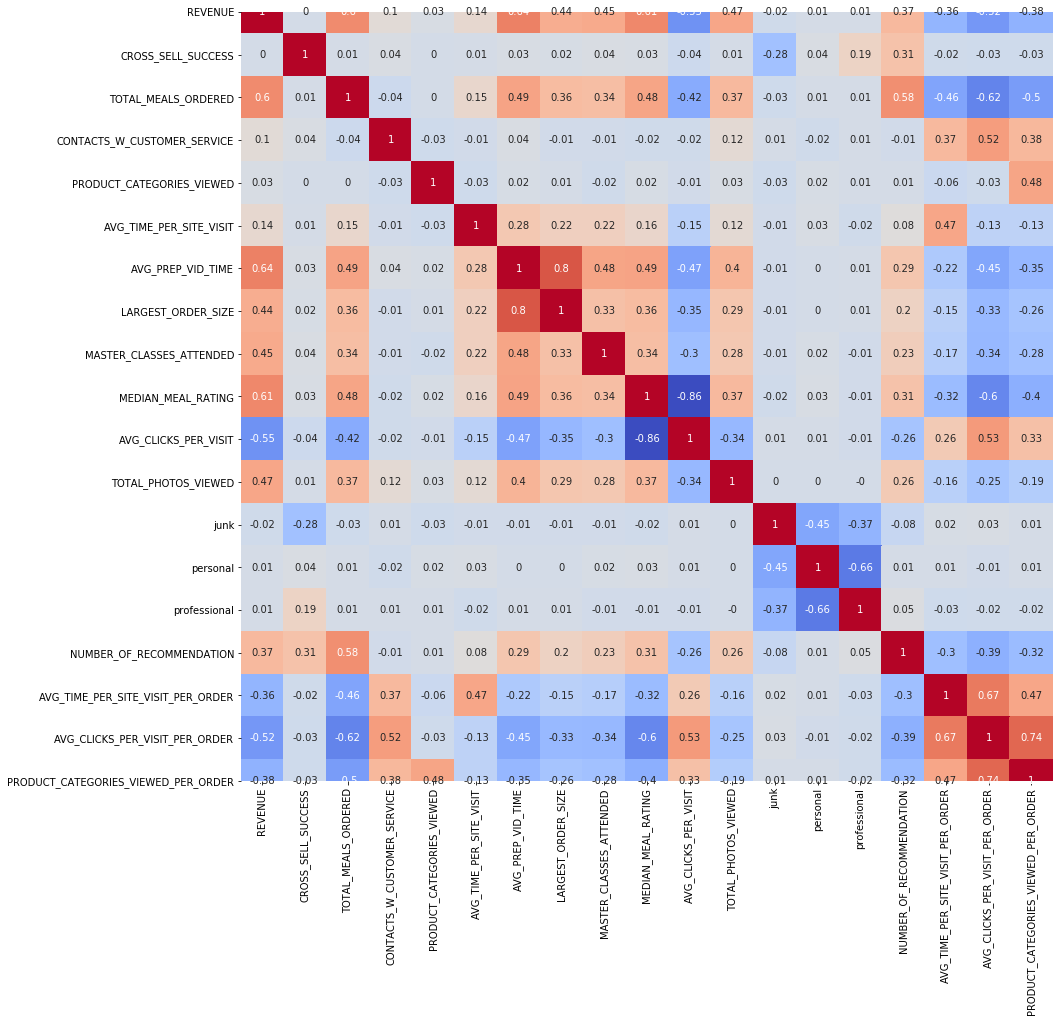

In [10]:
# subsetting the original dataset
apprend_subset = apprend.loc[ : , ['REVENUE', 'CROSS_SELL_SUCCESS', 'NAME', 'FIRST_NAME',
       'TOTAL_MEALS_ORDERED', 
       'CONTACTS_W_CUSTOMER_SERVICE', 'PRODUCT_CATEGORIES_VIEWED',
       'AVG_TIME_PER_SITE_VISIT', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE',
       'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT',
       'TOTAL_PHOTOS_VIEWED', 'junk', 'personal',
       'professional', 'NUMBER_OF_RECOMMENDATION',
       'AVG_TIME_PER_SITE_VISIT_PER_ORDER', 'AVG_CLICKS_PER_VISIT_PER_ORDER',
       'PRODUCT_CATEGORIES_VIEWED_PER_ORDER']]


# UNSCALED correlation matrix
apprend_corr = apprend_subset.corr().round(2)

# setting figure size and plot window
fig, ax = plt.subplots(figsize = (32, 32))
plt.subplot(1, 2, 1)

# heatmap of UNSCALED correlations
sns.heatmap(apprend_corr,
            cmap = 'coolwarm',
            square = True,
            annot = True,
            cbar = False) 

***
<h3>Splitting the Data</h3><br>
Splitting the data in a training group(75%) and a test group(25%).

***

In [11]:
#############################################################
#Set up train-test split ####################################
#############################################################

# declaring explanatory variables
apprend_data = apprend.drop(['CROSS_SELL_SUCCESS'], axis = 1)

#Dropping categorical variables
apprend_data = apprend_data.drop(columns= ['NAME','FIRST_NAME'])

# declaring response variable
apprend_target = apprend.loc[ : ,'CROSS_SELL_SUCCESS']

# train-test split
X_train, x_test, y_train, y_test = train_test_split(
            apprend_data,
            apprend_target,
            test_size = 0.25,
            random_state = 222,
            stratify = apprend_target)

# merging training data for statsmodels
apprend_train = pd.concat([X_train, y_train], axis = 1)

#apprend_train.info()
#apprend_train

In [12]:
##############################################################################
# (Re)Creates a dataframe with the result of each run of each model
##############################################################################
total_performance = pd.DataFrame(columns=['Model', 'Training', 'Testing'])

***
<h3>Logistic Regression</h3><br>
Creating a logistic regression model.After eliminate the variables with p-value greater than 0.05, the model remaning variables is show above.

The significant explanatory varibles are TOTAL_MEALS_ORDERED, MOBILE_NUMBER, TASTES_AND_PREFERENCES, junk, professional and NUMBER_OF_RECOMMENDATION. 
***

In [13]:
#############################################################
#Build a logistic regression model ##########################
#############################################################

# instantiating 
logistic = smf.logit(formula = """ CROSS_SELL_SUCCESS ~ TOTAL_MEALS_ORDERED+
                                                        MOBILE_NUMBER+
                                                        TASTES_AND_PREFERENCES+
                                                        junk+
                                                        professional+
                                                        NUMBER_OF_RECOMMENDATION
                                                        """,
                                                        data = apprend_train)

# fitting the model object
results_logistic = logistic.fit()


# checking the results SUMMARY
results_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.480126
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1452
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 Mar 2020   Pseudo R-squ.:                  0.2354
Time:                        15:36:35   Log-Likelihood:                -700.50
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 4.985e-90
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.3798      0.236     -1.608      0.108      -0.843       0.083
TOTAL_MEALS_ORDERED         -0.0123      0.002     -8.022      0.000      -0.015      -0.009
MOBILE_NUMBER                0.6783      0.191      3.555      0.000       0.304       1.052
TASTES_AND_PREFERENCES       0.3000      0.144      2.089      0.037       0.019       0.581
junk                        -1.2716      0.167     -7.633      0.000      -1.598      -0.945
professional                 0.6121      0.154      3.979      0.000       0.311       0.914
NUMBER_OF_RECOMMENDATION     0.0678      0.005     12.422      0.000       0.057       0.079
============================================================================================
"""

In [14]:
################################################################################
#Logistic Regression Model######################################################
################################################################################

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 222)

# FITTING the training data
logreg_fit = logreg.fit(X_train,y_train)

# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# area under the roc curve (auc)
logreg_auc = roc_auc_score(y_true  = y_test,
              y_score = logreg_pred).round(4)

# creating an empty list
model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]

# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)


# test accuracy
logreg_test_acc   = logreg_fit.score(x_test, y_test).round(4)


# saving the results
model_performance.append(['Logistic Regression',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

for model in model_performance:
    print(model)

['Model', 'Training Accuracy', 'Testing Accuracy', 'AUC Value']
['Logistic Regression', 0.6813, 0.6858, 0.6113]


C:\Users\patty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


***
<h3>Evaluating the model</h3><br>

In term of our model, confusion matrix can be read as follows:
~~~
           True Negatives(correct)                        |        False Positives(incorrect)
  PREDICTED:DID NOT Subscribe (CROSS_SELL_SUCCESS = 0)    |  PREDICTED:  Subscribe (CROSS_SELL_SUCCESS = 1)
  ACTUAL:   DID NOT Subscribe (CROSS_SELL_SUCCESS = 0)    |  ACTUAL:  DID NOT Subscribe (CROSS_SELL_SUCCESS = 0)
                                                          |
----------------------------------------------------------|-------------------------------------------
              False Negatives                             |         True positives (corrects)
  PREDICTED: DID NOT Subscribe (CROSS_SELL_SUCCESS = 0)   |  PREDICTED:  Subscribe  (CROSS_SELL_SUCCESS = 1)
  ACTUAL: Subscribe (CROSS_SELL_SUCCESS = 1)              |  ACTUAL:     Subscribe  (CROSS_SELL_SUCCESS = 1)
                                                          |  
~~~
***

[[ 63  93]
 [ 60 271]]


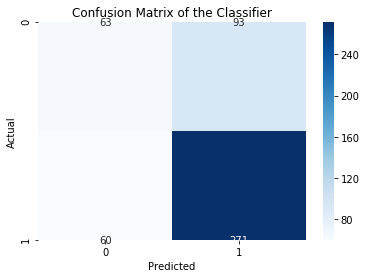

In [15]:
################################################################################
# Evaluating the Model##########################################################
################################################################################

def visual_cm(true_y, pred_y):
    

    # visualizing the confusion matrix

        # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)
    print(cm)
    
    # heatmap
    sns.heatmap(cm,
                annot       = True,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
    
visual_cm(true_y = y_test, 
          pred_y = logreg_pred)
          


In [16]:
false_negative = 60/(63+60)*100
false_positive = 93/(271+93)*100

print(f'The percentage of false negatives is ' + str(false_negative) + '% and the percentage of false positives is ' + str(false_positive) + '%.')

The percentage of false negatives is 48.78048780487805% and the percentage of false positives is 25.549450549450547%.


The percentage of false negatives is 48.78048780487805% and the percentage of false positives is 25.549450549450547%.

The percentage of false negatives is higher than false positive, this result is good because it is better expect the client not subscribe to CROSS_SELL_SUCCESS and he/she subscribes, than the other way. 

***
***
<h3>CART Model and Features Importance</h3><br>

In [17]:
def display_tree(tree, feature_df, height = 1500, width = 800):
    
    # visualizing the tree
    dot_data = StringIO()

    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    max_depth          = 5,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    print(img)
    return img

 # INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 4,
                                          min_samples_leaf = 25,
                                          random_state = 802)


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4))


# calling display_tree
display_tree(tree       = tree_pruned_fit,
             feature_df = X_train)   


Training ACCURACY: 0.7663
Testing  ACCURACY: 0.7372
AUC Score        : 0.6541


InvocationException: GraphViz's executables not found

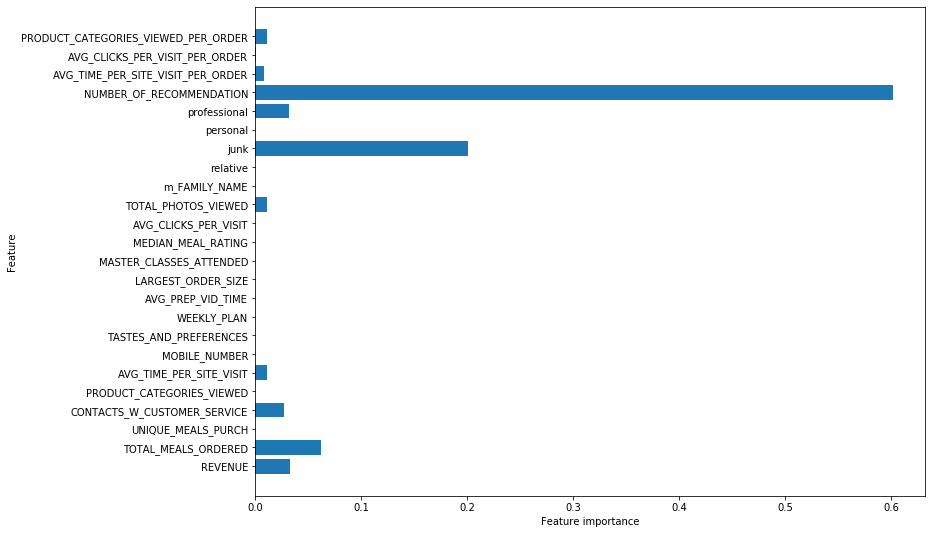

In [18]:
def plot_feature_importances(model, train, export = False):
        
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
   # plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

The feature most important in term of splitting the data is NUMBER OF RECOMMENDATION. On second place is 
junk mail, third TOTAL_MEALS_ORDERED.

***
***
<h3>Model with specific variables</h3><br>

In [19]:
new_apprendX = apprend.drop(columns = ['CROSS_SELL_SUCCESS', 'NAME','FIRST_NAME',
                                       'UNIQUE_MEALS_PURCH',
                                       'MOBILE_NUMBER', 'TASTES_AND_PREFERENCES',
                                       'WEEKLY_PLAN', 'AVG_PREP_VID_TIME', 'LARGEST_ORDER_SIZE',
                                       'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT',
                                       'm_FAMILY_NAME', 'relative', 'personal',
                                       'AVG_CLICKS_PER_VISIT_PER_ORDER',
                                       'PRODUCT_CATEGORIES_VIEWED_PER_ORDER'])


# Preparing training and testing sets
X_train, x_test, y_train, y_test = train_test_split(
            new_apprendX,
            apprend_target,
            test_size = 0.25,
            random_state = 222)

# Merging X_train and y_train so that they can be used in statsmodels
apprend_train = pd.concat([X_train, y_train], axis = 1)

# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 222)


# FITTING the training data
logreg_fit = logreg.fit(X_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# area under the roc curve (auc)
logreg_auc = roc_auc_score(y_true  = y_test,
              y_score = logreg_pred).round(4)

# creating an empty list
model_performance = [['Model', 'Training Accuracy',
                      'Testing Accuracy', 'AUC Value']]


# train accuracy
logreg_train_acc  = logreg_fit.score(X_train, y_train).round(4)


# test accuracy
logreg_test_acc   = logreg_fit.score(x_test, y_test).round(4)


# saving the results
model_performance.append(['Logistic Regression',
                          logreg_train_acc,
                          logreg_test_acc,
                          logreg_auc])

# checking the results
for model in model_performance:
    print(model)


['Model', 'Training Accuracy', 'Testing Accuracy', 'AUC Value']
['Logistic Regression', 0.6854, 0.6653, 0.5765]


C:\Users\patty\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[ 51 108]
 [ 55 273]]


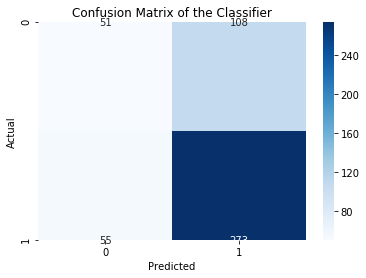

In [20]:
def visual_cm(true_y, pred_y):

    # visualizing the confusion matrix

        # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)
    print(cm)
    
    # heatmap
    sns.heatmap(cm,
                annot       = True,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
    
visual_cm(true_y = y_test, pred_y = logreg_pred)


In [ ]:
false_negative = 55/(55+51)*100
false_positive = 108/(108+273)*100


print(f'The percentage of false negatives is ' + str(false_negative) + '% and the percentage of false positives is ' + str(false_positive) + '%.')

The percentage of false negatives is 51.886792452830186% and the percentage of false positives is 28.346456692913385%.

The percentage of false negatives is higher than false positive, this result is good because it is better expect the client not subscribe to CROSS_SELL_SUCCESS and he/she subscribes, than the other way.

Although, comparing to previous model, the percentage of false negative(FN) and false positive(FP) increased. (FN: 48%->52% and FP:25%->28%) 

***
<h3>CART Model and Features Importance for specific variables</h3><br>

In [21]:
def display_tree(tree, feature_df, height = 1500, width = 800):
    
    # visualizing the tree
    dot_data = StringIO()

    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    max_depth          = 5,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    print(img)
    return img

# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 4,
                                          min_samples_leaf = 25,
                                          random_state = 802)


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(3))
print('Testing  ACCURACY:', tree_pruned_fit.score(x_test, y_test).round(3))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(3))


# calling display_tree
display_tree(tree       = tree_pruned_fit,
             feature_df = X_train)    


Training ACCURACY: 0.7574
Testing  ACCURACY: 0.7351
AUC Score        : 0.6624


InvocationException: GraphViz's executables not found